# classification es el notebook oficial de clasificación

### - Limpiamos los datos según conclusiones del notebook main
### - Probaremos distintos algorítmos de clasificación y compararemos los resultados
### - Utilizamos el dataset de train ya recortado por la cátedra (igual creamos un test para pruebas internas)

---





## ACA TODOS LOS IMPORTS DEL NOTEBOOK

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_auc_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay, plot_precision_recall_curve, plot_roc_curve 

## LECTURA Y LIMPIEZA DEL DATASET

In [76]:
df_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_train.csv",index_col=0)

In [77]:
df_cleaned = df_orig.copy()
feat_train, feat_test, targ_train, targ_test = train_test_split(df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"],test_size=0.2)

In [17]:
rfe = RFECV(RandomForestClassifier(n_estimators=2000),scoring="recall",min_features_to_select=5,cv=10,verbose=1,n_jobs=-1)
rfe = rfe.fit(feat_train,targ_train)

Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.


In [18]:
for feat in zip(feat_train.columns,rfe.support_):
    print(feat)

('age', True)
('anaemia', False)
('creatinine_phosphokinase', True)
('diabetes', False)
('ejection_fraction', True)
('high_blood_pressure', False)
('platelets', True)
('serum_creatinine', True)
('serum_sodium', True)
('sex', False)
('smoking', False)
('time', True)


## Transformaciones necesarias al df

In [78]:
#df_orig["cant_path"] = df_orig["anaemia"]+df_orig["high_blood_pressure"]+df_orig["diabetes"]
#df_cleaned = df_orig.copy()
df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
#df_cleaned = df_orig.drop(["anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
# NOS QUEDAMOS CON AGE, EJECTION_FRACTION, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT

In [79]:
df_cleaned.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT
55,95.0,371,30,461000.0,2.0,132,1
180,40.0,478,30,303000.0,0.9,136,0
237,70.0,232,30,173000.0,1.2,132,0
280,70.0,2695,40,241000.0,1.0,137,0
181,59.0,176,25,221000.0,1.0,136,1


In [80]:
feat_train, feat_test, targ_train, targ_test = train_test_split(df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"],test_size=0.2)
#HAY QUE SEPARAR EL TEST ANTES DE ESTANDARIZAR PARA QUE NO INFLUYAN LOS FEATURES DE TEST EN LA MEDIA Y VARIANZA

In [81]:
#APLICAMOS SMOTE PARA AUMENTAR LA CANTIDAD DE SAMPLES Y BALANCEAR EL TARGET
feat_train, targ_train = SMOTE().fit_resample(feat_train, targ_train)

In [88]:
#NO ES NECESARIO EN CIERTOS ALGORITMOS VER
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)
t_var = scaler.var_ # ESTA VARIANZA HAY Q USAR PARA STANDARIZAR EL TARG_TEST
t_mean = scaler.mean_ # ESTA MEDIA HAY Q USAR PARA STANDARIZAR EL TARG_TEST

## ACA TENEMOS EL DATASET RECORTADO Y STANDARIZADO 

In [85]:
#sss = StratifiedShuffleSplit() # USAMOS ESTO PARA CV POR EL DESBALANCE (si usamos smote no hay desbalance)

In [82]:
score_metric = "recall" # Queremos pocos FN, es decir pacientes q decimos q NO tienen riesgo pero SI.

---
---
---

# LOGISTIC REGRESSION

### La teoría indica que el Logistic Regressor no tiene hyperparametros q valgan la pena tunear mas allá del penalty o un poco el "C".

In [89]:
hyperparam = {"poly__degree":[n for n in range(1,5)],"regressor__C":[n for n in np.logspace(-20,2, num=40)]}
lr_model = Pipeline([["poly",PolynomialFeatures()],["regressor",LogisticRegression(fit_intercept=False, max_iter=20000)]])
lr_grilla = GridSearchCV(lr_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
lr_grilla.fit(feat_train,targ_train)
lr_model = lr_grilla.best_estimator_
print(lr_grilla.best_params_)
print("Grilla Best Score: {:.3f}".format(lr_grilla.best_score_))
lr_scoring = cross_val_score(lr_model, feat_train, targ_train,cv=10, scoring=score_metric)
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(lr_scoring.mean(),lr_scoring.std()))

{'poly__degree': 4, 'regressor__C': 0.151177507061566}
Grilla Best Score: 0.795
Cross Validation Score: 0.795 +/- 0.127


In [94]:
print("Scoring en Test: {:.3f}".format(recall_score(targ_test,lr_model.predict((feat_test-t_mean)/t_var))))

Scoring en Test: 0.474


---

# SUPPORT VECTOR MACHINES

In [95]:
hyperparam = {"poly__degree":[n for n in range(1,4)],"SVC__C":[n for n in np.logspace(-80,-15, num=25)]}
svml_model = Pipeline([["poly",PolynomialFeatures()],["SVC",LinearSVC(loss='hinge', fit_intercept=False, max_iter=30000)]])
svml_grilla = GridSearchCV(svml_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
svml_grilla.fit(feat_train,targ_train)
print(svml_grilla.best_params_)
svml_model = svml_grilla.best_estimator_
print("Grilla Best Score: {:.3f}".format(svml_grilla.best_score_))
svml_scoring = cross_val_score(svml_model, feat_train, targ_train,cv=10, scoring=score_metric)
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(svml_scoring.mean(),svml_scoring.std()))

{'SVC__C': 1e-80, 'poly__degree': 2}
Grilla Best Score: 0.757
Cross Validation Score: 0.757 +/- 0.124


In [97]:
print("Scoring en Test: {:.3f}".format(recall_score(targ_test,svml_model.predict((feat_test-t_mean)/t_var))))

Scoring en Test: 0.632


---

# SVM no lineal

In [98]:
hyperparam = {"kernel":["rbf","poly","sigmoid"],"C":[n for n in np.logspace(-1,1, num=25)],"gamma":[n for n in np.logspace(-2,0, num=25)]}
svm_model = SVC()
svm_grilla = GridSearchCV(svm_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
svm_grilla.fit(feat_train,targ_train)
print(svm_grilla.best_params_)
svm_model = svm_grilla.best_estimator_
print("Grilla Best Score: {:.3f}".format(svm_grilla.best_score_))
svm_scoring = cross_val_score(svm_model, feat_train, targ_train,cv=10, scoring=score_metric)
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(svm_scoring.mean(),svm_scoring.std()))

{'C': 0.1, 'gamma': 0.3831186849557287, 'kernel': 'poly'}
Grilla Best Score: 0.831
Cross Validation Score: 0.831 +/- 0.123


In [99]:
print("Scoring en Test: {:.3f}".format(recall_score(targ_test,svm_model.predict((feat_test-t_mean)/t_var))))

Scoring en Test: 0.895


---

# DECISION TREE

max_depth: por defecto es None, controla la profundidad del arbol.
min_samples_split: establece el minimo numero de muestras que debe tener un nodo para poder seguir partiendolo.
min_samples_leaf: el minimo numero de muestras que debe tener una hoja (ie nodo final).
min_weight_fraction_leaf: la minima fraccion pesada de muestras que debe poseer una hoja.
max_leaf_nodes: maxima cantidad de hojas.
max_features: maxima cantidad de features evaluados en un splitting.

In [100]:
hyperparam = {"max_depth":[n for n in range(2,7)],"max_leaf_nodes":[2,10,50,500,1000]}
dt_model = DecisionTreeClassifier()
dt_grilla = GridSearchCV(dt_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
dt_grilla.fit(feat_train,targ_train)
print(dt_grilla.best_params_)
dt_model = dt_grilla.best_estimator_
print("Grilla Best Score: {:.3f}".format(dt_grilla.best_score_))
dt_scoring = cross_val_score(dt_model, feat_train, targ_train,cv=10, scoring=score_metric)
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(dt_scoring.mean(),dt_scoring.std()))

{'max_depth': 6, 'max_leaf_nodes': 1000}
Grilla Best Score: 0.752
Cross Validation Score: 0.759 +/- 0.164


In [101]:
print("Scoring en Test: {:.3f}".format(recall_score(targ_test,dt_model.predict((feat_test-t_mean)/t_var))))

Scoring en Test: 0.316


---

# RANDOM FOREST

In [102]:
hyperparam = {"n_estimators":[100,200,500],"max_depth":[n for n in range(2,8)],"min_samples_leaf":[2,10]}
rf_model = RandomForestClassifier()
rf_grilla = GridSearchCV(rf_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
rf_grilla.fit(feat_train,targ_train)
rf_model = rf_grilla.best_estimator_
print(rf_grilla.best_params_)
print("Grilla Best Score: {:.3f}".format(rf_grilla.best_score_))
rf_scoring = cross_val_score(rf_model, feat_train, targ_train,cv=10, scoring=score_metric)
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(rf_scoring.mean(),rf_scoring.std()))

{'max_depth': 4, 'min_samples_leaf': 10, 'n_estimators': 200}
Grilla Best Score: 0.795
Cross Validation Score: 0.757 +/- 0.122


In [103]:
print("Scoring en Test: {:.3f}".format(recall_score(targ_test,rf_model.predict((feat_test-t_mean)/t_var))))

Scoring en Test: 0.632


---


# ADABOOST CLASIFFIER

In [104]:
hyperparam = {"n_estimators":[100,500,1000,5000],"learning_rate":[0.1,0.3,0.5,1]}
ada_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=7), algorithm="SAMME.R")
ada_grilla = GridSearchCV(ada_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
ada_grilla.fit(feat_train,targ_train)
ada_model = rf_grilla.best_estimator_
print(ada_grilla.best_params_)
print("Grilla Best Score: {:.3f}".format(ada_grilla.best_score_))
ada_scoring = cross_val_score(ada_model, feat_train, targ_train,cv=10, scoring=score_metric)
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(ada_scoring.mean(),ada_scoring.std()))

{'learning_rate': 1, 'n_estimators': 100}
Grilla Best Score: 0.848
Cross Validation Score: 0.765 +/- 0.120


In [105]:
print("Scoring en Test: {:.3f}".format(recall_score(targ_test,ada_model.predict((feat_test-t_mean)/t_var))))

Scoring en Test: 0.632


---

# XGBOOST

In [39]:
feat_train_2, feat_val, targ_train_2, targ_val = train_test_split(feat_train,targ_train)
# NECESARIO CREAR DATOS DE VALIDACION PARA USAR XGBC

In [40]:
xgbc_model = XGBClassifier(use_label_encoder=False, n_estimators=500, learning_rate=0.5, objective='binary:hinge', max_depth=7)
xgbc_model.fit(feat_train_2,targ_train_2,eval_set=[(feat_train_2, targ_train_2), (feat_val, targ_val)],eval_metric='logloss',early_stopping_rounds=20,verbose=False)
xgbc_scoring = cross_val_score(ada_model, feat_train, targ_train,cv=10, scoring=score_metric)
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(xgbc_scoring.mean(),xgbc_scoring.std()))
# VER TEMA DE METRICA ACA

Cross Validation Score: 0.825 +/- 0.183


In [74]:
xgbc_model.predict(feat_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

NameError: name 'lr_model' is not defined

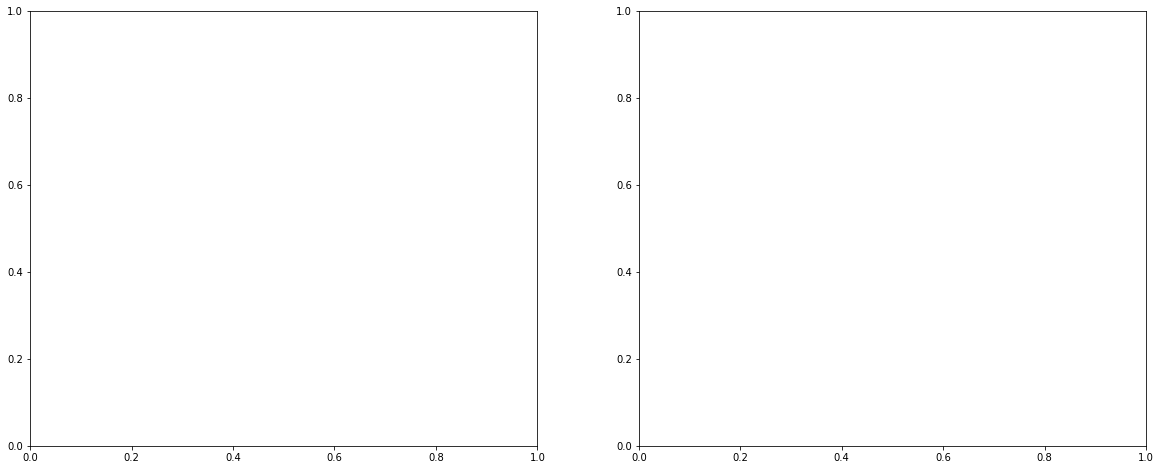

In [33]:
#ESTO ESTÁ MAL PORQ ESTOY VIENDO RESULTADOS DEL GRID Y NO DEL CROSS VALIDATION

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
modelos = []
n=0
for modelo in []:
